A notebook which contains an evaluation of the SalishSeaCast model within PugetSound for the year 2010. More specifically, it compares Observed data on temperature, salinity, and chlorophyll concentrations  collected from CTD data and compares it to various model phytoplankon outputs. This evaluation includes scatter plots and 2d histograms visualizing the similarity of observed and model data as well as tables of evaluation statistics. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=[2009,2010]
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2010

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of chlorophyll, temperature and salinity between 201905 runs and CTD observations

In [6]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
with open(os.path.join(saveloc,f'data_CTD_{modelversion}_{year}.pkl'),'rb') as hh:
    data_all=pickle.load(hh)

In [7]:
#Adding extra columns to assist in analysis.
data_all['log_Chl']=ket.logt(data_all['Chl'])
data_all['log_mod_diatoms']=ket.logt(data_all['mod_diatoms']*1.8)
data_all['log_mod_ciliates']=ket.logt(data_all['mod_ciliates']*1.8)
data_all['log_mod_flagellates']=ket.logt(data_all['mod_flagellates']*1.8)
data_all['mod_Chl']=((data_all['mod_diatoms']*1.8)+(data_all['mod_ciliates']*1.8)+(data_all['mod_flagellates']*1.8))
data_all['log_mod_Chl']=ket.logt((data_all['mod_diatoms']*1.8)+(data_all['mod_ciliates']*1.8)+(data_all['mod_flagellates']*1.8))


In [8]:
# Creating seperate dataframes for each season (includes only dataabove 15 metre depth.)
iz=(data_all.Z<15)
DJF_CTD=data_all.loc[iz&(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],3,1)),:]
MAM_CTD=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],5,1))&(data_all.dtUTC>dt.datetime(years[1],4,1)),:]
JJA_CTD=data_all.loc[iz&(data_all.dtUTC<=dt.datetime(years[1],9,1))&(data_all.dtUTC>dt.datetime(years[1],5,1)),:]
SON_CTD=data_all.loc[iz&(data_all.dtUTC>dt.datetime(years[1],9,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [9]:
data_CTD=data_all.loc[(data_all.dtUTC>=dt.datetime(years[0],12,1))&(data_all.dtUTC<=dt.datetime(years[1],11,30)),:]

In [10]:
# defning a dictionary that brakes the data down by individual stations
datstat_CTD=dict()
for ind, istation in enumerate(data_CTD.Station.unique()):
    datstat_CTD[istation]=data_CTD.loc[data_CTD.Station == istation]

datreg_CTD=dict()
for iregion in data_CTD.Basin.unique():
    datreg_CTD[iregion] = data_CTD.loc[data_CTD.Basin==iregion]

In [11]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs_CTD=OrderedDict({'z < 15 m':data_CTD.loc[data_CTD.Z<15],
                      '15 m < z < 22 m':data_CTD.loc[(data_CTD.Z>=15)&(data_CTD.Z<22)],
                      'z >= 22 m':data_CTD.loc[data_CTD.Z>=22],
                      'z > 50 m':data_CTD.loc[data_CTD.Z>50],
                      'all':data_CTD,
                      'z < 15 m, DJF':DJF_CTD,
                      'z < 15 m, MAM':MAM_CTD,
                      'z < 15 m, JJA':JJA_CTD,
                      'z < 15 m, SON': SON_CTD})
for iregion in data_CTD.Basin.unique():
    statsubs_CTD[iregion]=datreg_CTD[iregion]
statsubs_CTD.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, DJF', 'z < 15 m, MAM', 'z < 15 m, JJA', 'z < 15 m, SON', 'Main Basin', 'Hood Canal Basin', 'South Basin', 'Admiralty Inlet', 'Whidbey Basin', 'Strait of Georgia', 'Strait of Juan de Fuca'])

## Map of observation locations in each basin

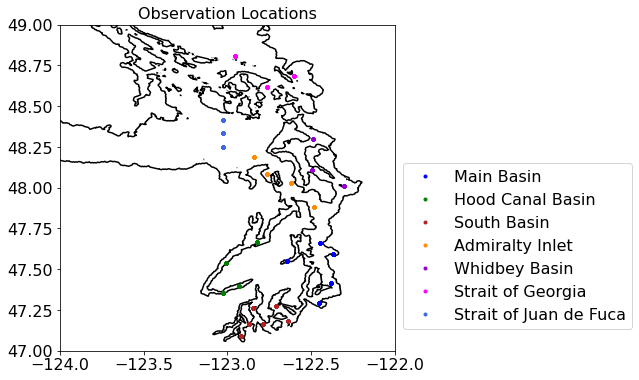

In [12]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data_CTD.Basin.unique()):
    ax.plot(datreg_CTD[iregion]['Lon'], datreg_CTD[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Absolute Salinity (g/kg)

### Table containing evaluation statistics for relevant subsets

In [13]:
# Setting Variable for Temperature. 
obsvar='SA'
modvar='mod_vosaline'
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

In [14]:
statsDict_CTSA={year:dict()}
statsDict_CTSA[year]['SA']=OrderedDict()
for isub in statsubs_CTD:
    print(isub)
    statsDict_CTSA[year]['SA'][isub]=dict()
    var=statsDict_CTSA[year]['SA'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTSA[year]['SA'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, DJF
z < 15 m, MAM
z < 15 m, JJA
z < 15 m, SON
Main Basin
Hood Canal Basin
South Basin
Admiralty Inlet
Whidbey Basin
Strait of Georgia
Strait of Juan de Fuca


### Model vs Observed comparisons by depth and region

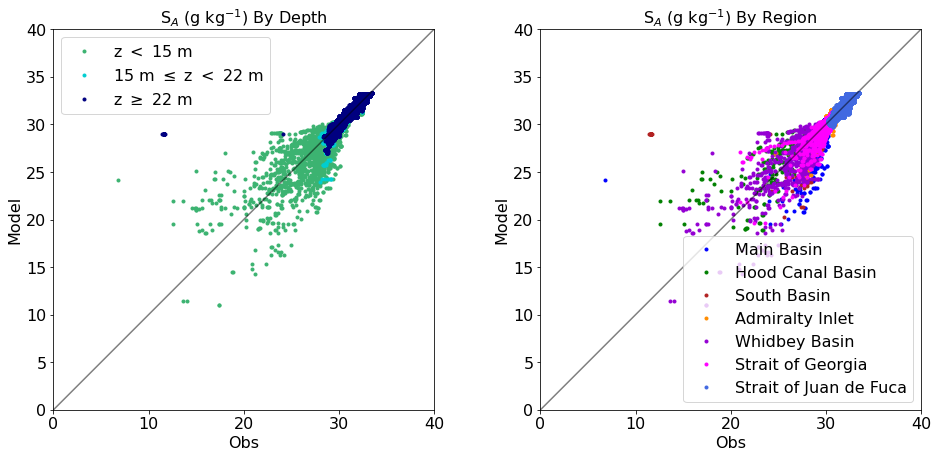

In [15]:
lims=(0,40)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

### A closer look at Salinity in South Basin

### 2D Histogram of model vs observed

Text(0.5, 1.0, 'S$_A$ (g kg$^{-1}$)')

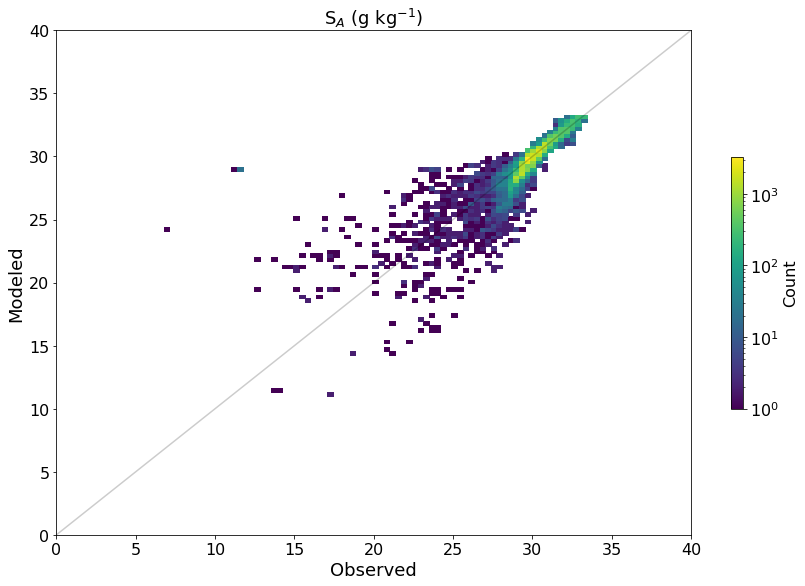

In [16]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,lims,fontsize=18)
ax.set_title('S$_A$ (g kg$^{-1}$)',fontsize=18)

### 2d histograms of individual regions

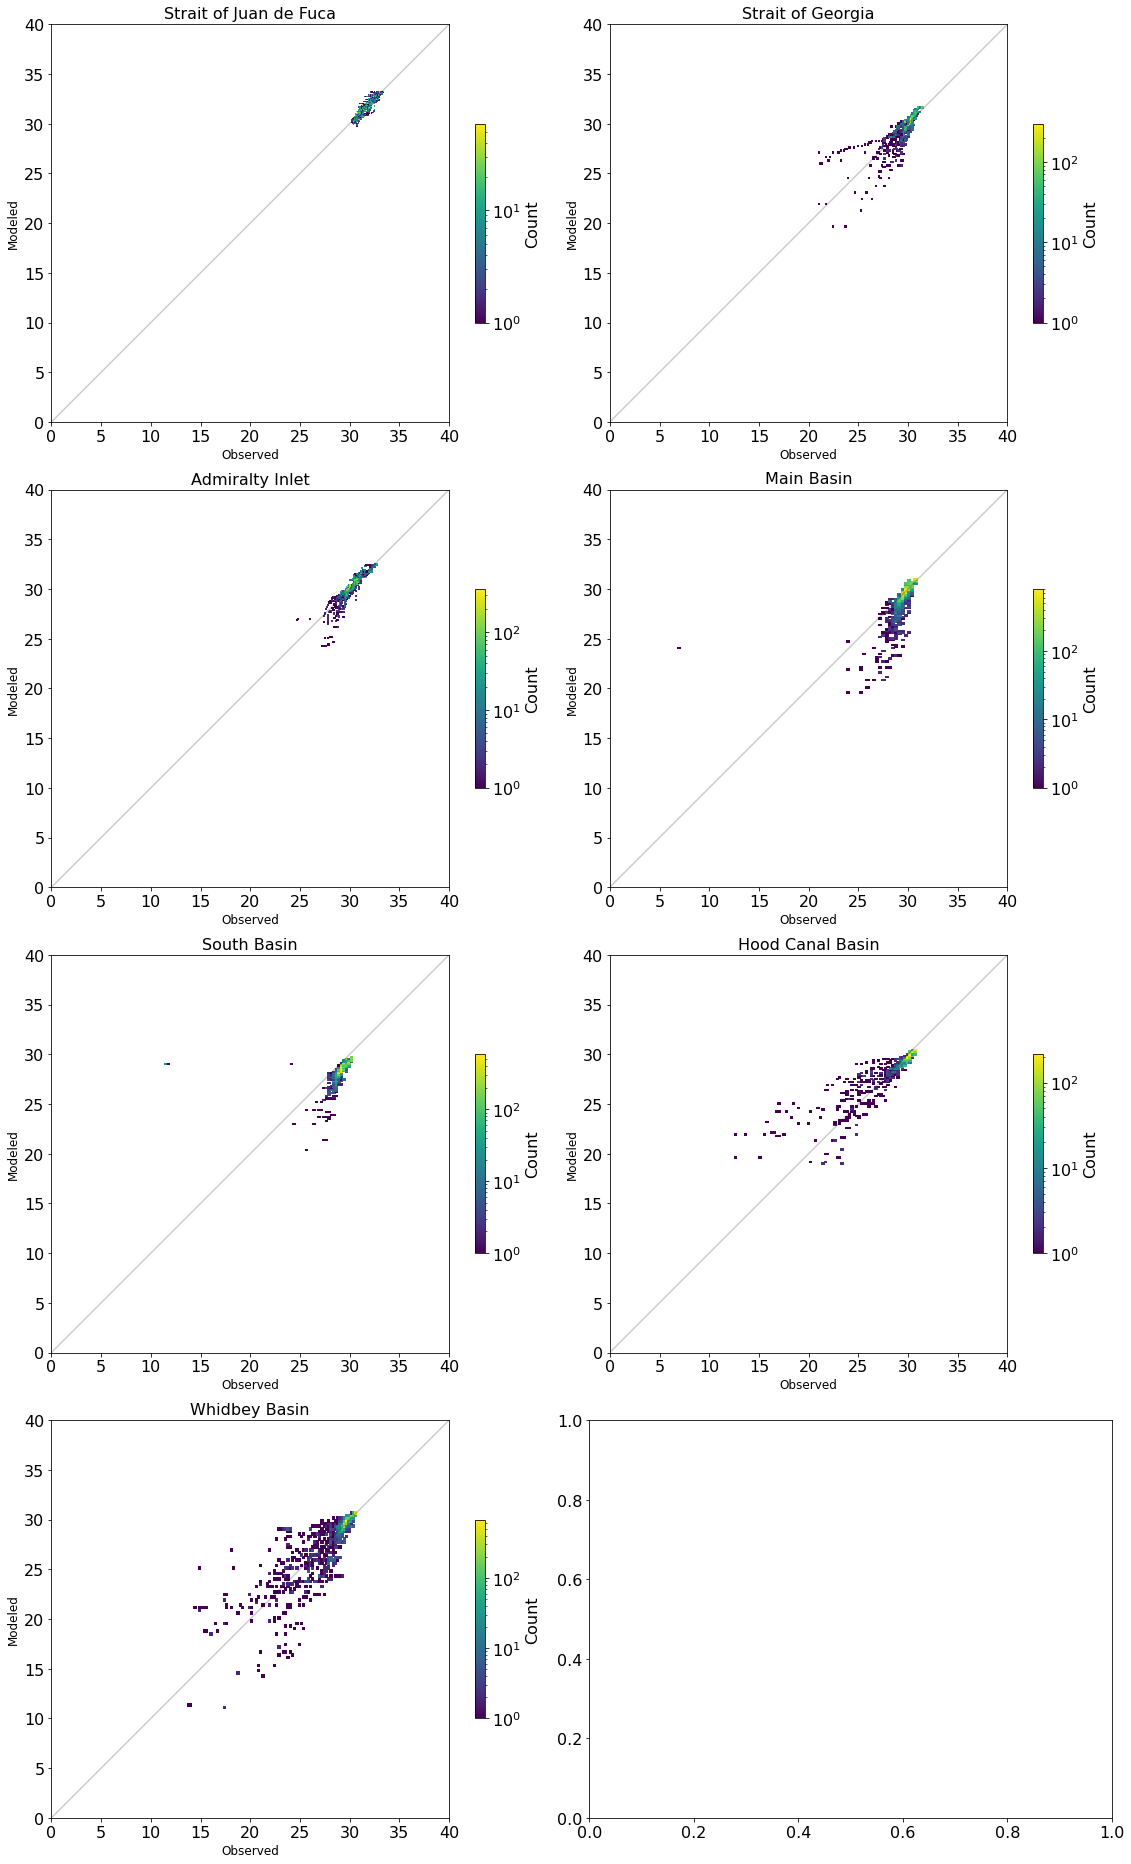

In [17]:
ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model vs observed comparisons for multiple seasons

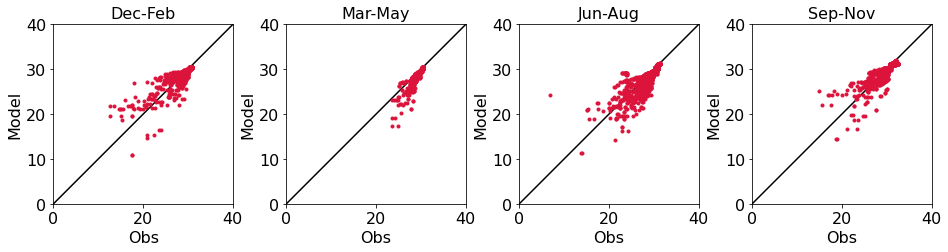

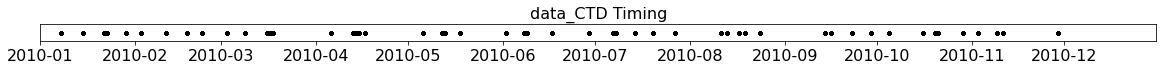

In [18]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

# Conservative Temperature

In [19]:
#Setting variables for temperature.
obsvar='CT'
modvar='mod_votemper'

### Table containing evaluation statistics for relevant subsets

In [20]:
statsDict_CTSA[year]['CT']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_CTSA[year]['CT'][isub]=dict()
    var=statsDict_CTSA[year]['CT'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]],
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_CTSA[year]['CT'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Model vs Observed comparisons by depth and region

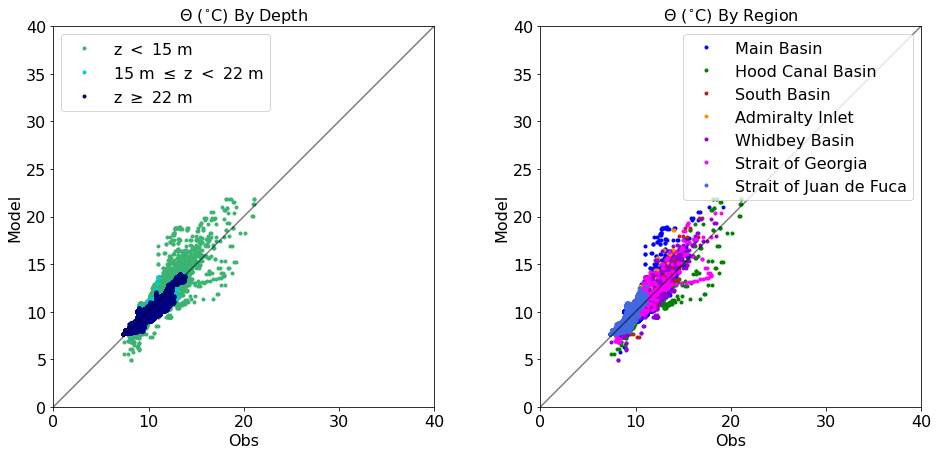

In [21]:
lims=(0,40)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

### 2D Histogram of model vs observed

Text(0.5, 1.0, '$\\Theta$ ($^{\\circ}$C)')

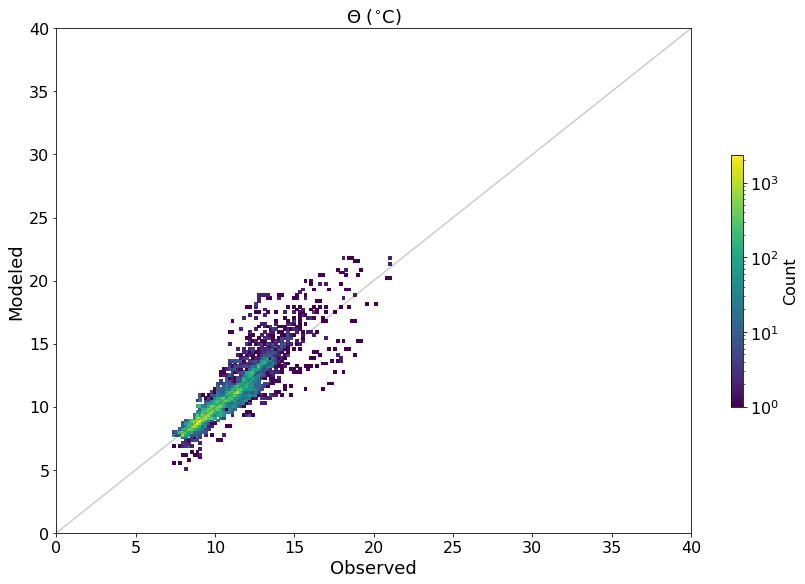

In [22]:
fig, ax = plt.subplots(1,1,figsize= (12,8))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,lims,fontsize=18)
ax.set_title('$\Theta$ ($^{\circ}$C)',fontsize=18)

### 2d histograms of individual regions

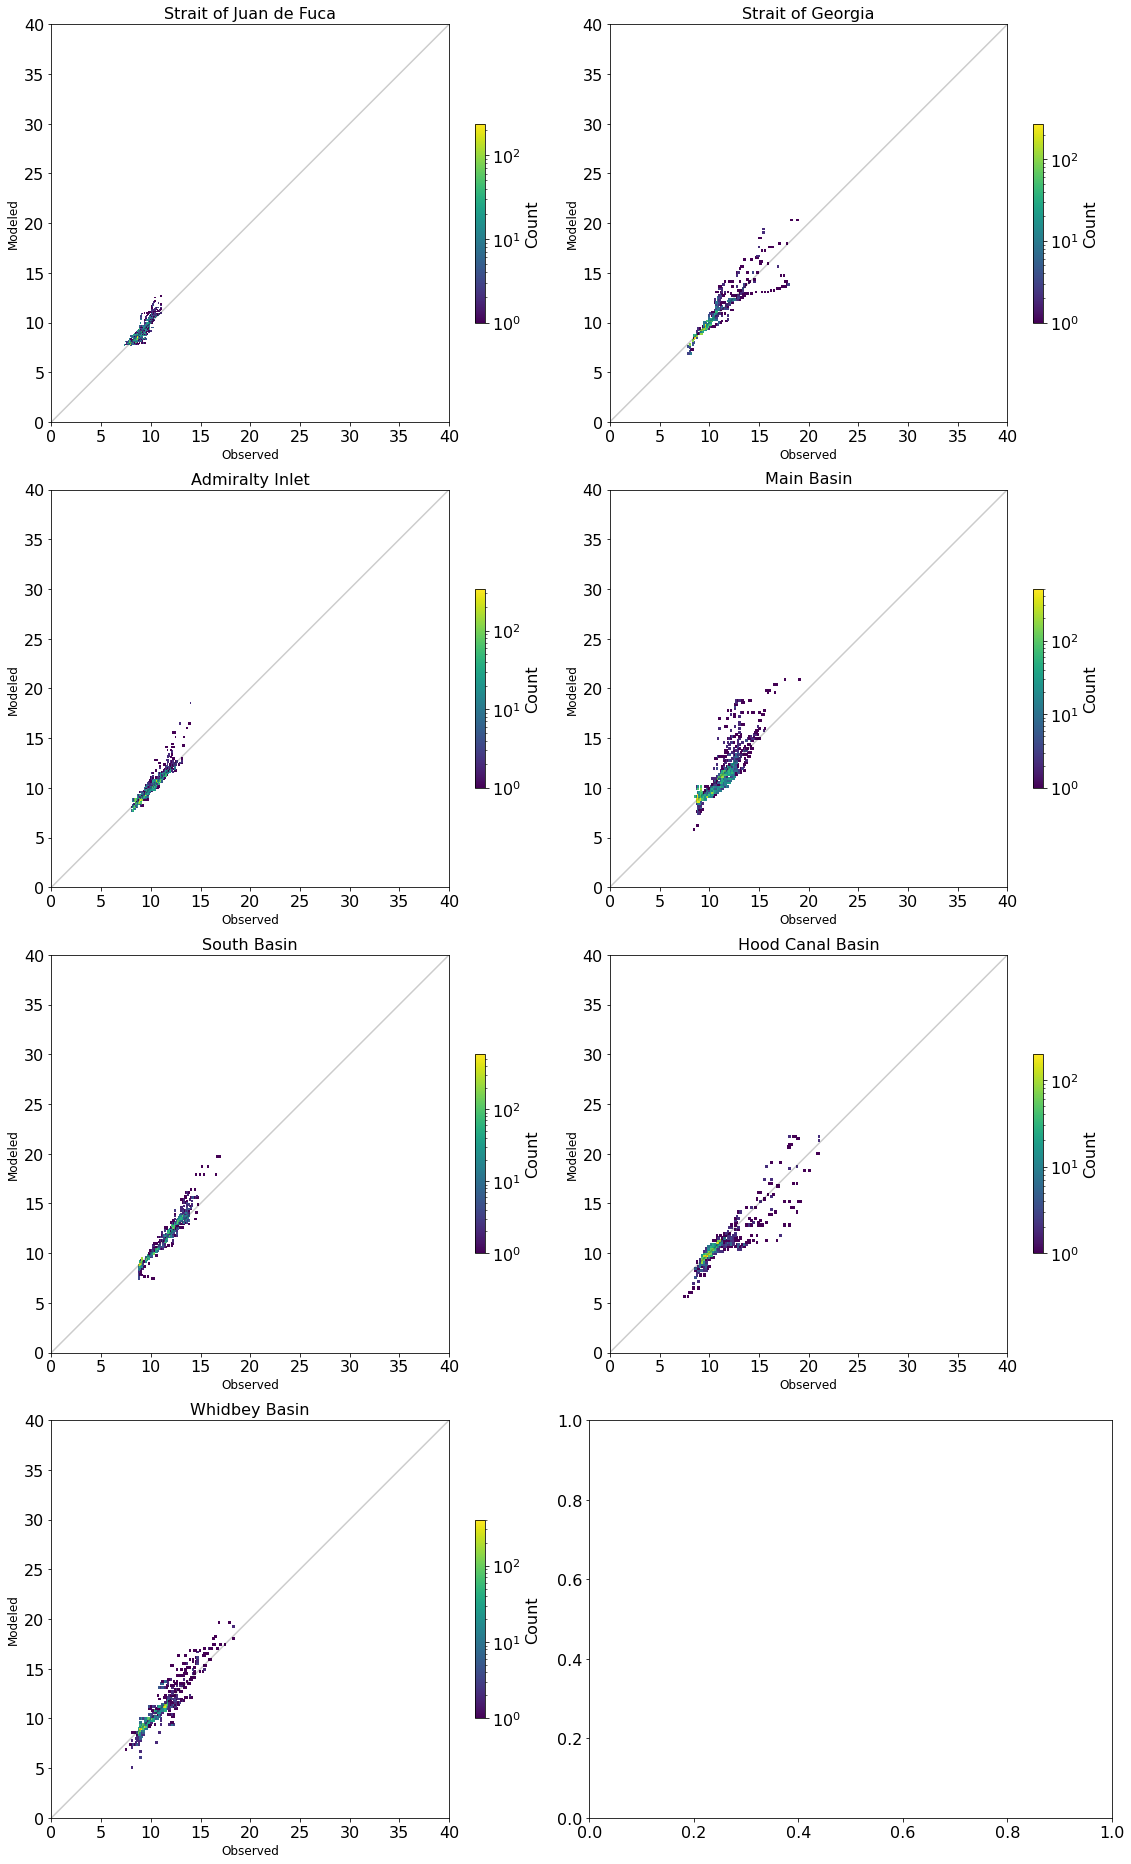

In [23]:
ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model vs observed comparisons for multiple seasons

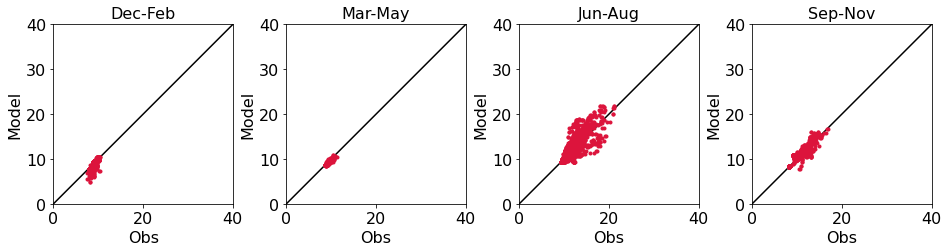

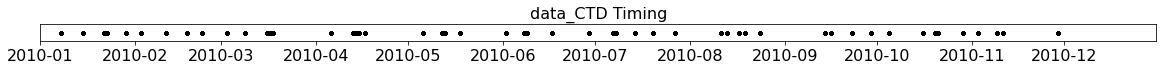

In [24]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Temperature-Salinity by Region

In [25]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,20)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps=list()
    for ind, iregion in enumerate(data_CTD.Basin.unique()):
        p=ax.plot(datreg_CTD[iregion][svar], datreg_CTD[iregion][tvar],'.',
                color = colors[ind], label=iregion)
        ps.append(p[0])
    l=ax.legend(handles=ps,bbox_to_anchor=(1.01,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

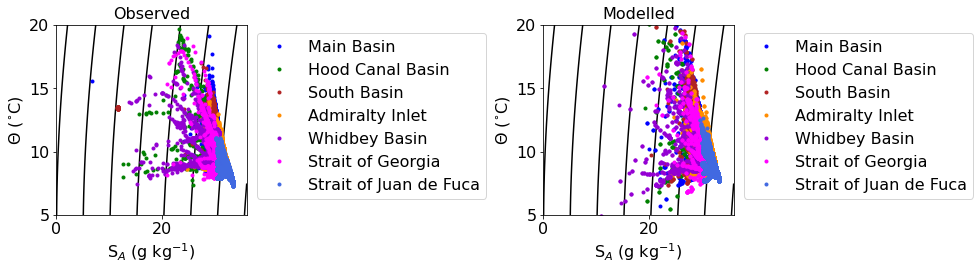

In [26]:
fig,ax=plt.subplots(1,2,figsize=(16,3.5))
tsplot(ax[0],'SA','CT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

### Summary table of temperature and salinity evaluation statistics

In [27]:
#No longer entirely accurate, should create seperate ones for each of the chlorophyll 
#comparisons and the CT SA analysis. Also should probably not log transform for the table.
tbl,tdf=et.displayStats(statsDict_CTSA[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl

# Observed Chlorophyll vs Model Phytoplankton

In [28]:
#Setting variables for Chlorophyll.
obsvar='Chl'
modvar='mod_diatoms'

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [29]:
statsDict_Chl={year:dict()}
statsDict_Chl[year]['Diatoms']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Diatoms'][isub]=dict()
    var=statsDict_Chl[year]['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Diatoms'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

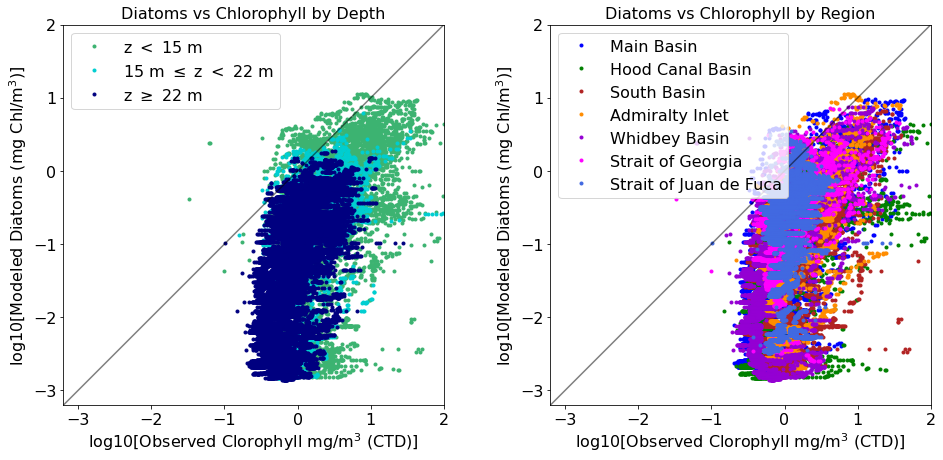

In [30]:
obsvar='log_Chl'
modvar='log_mod_diatoms'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Diatoms vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')   

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Diatoms vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of model diatoms vs observed cholophyll

Text(0.5, 28.0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

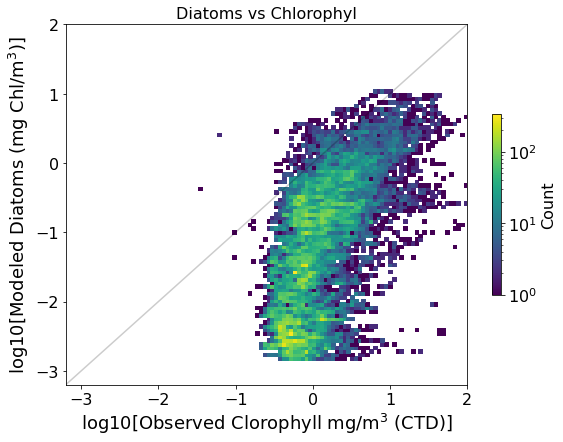

In [31]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Diatoms vs Chlorophyl')
ax.set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  

### 2d histograms of individual regions

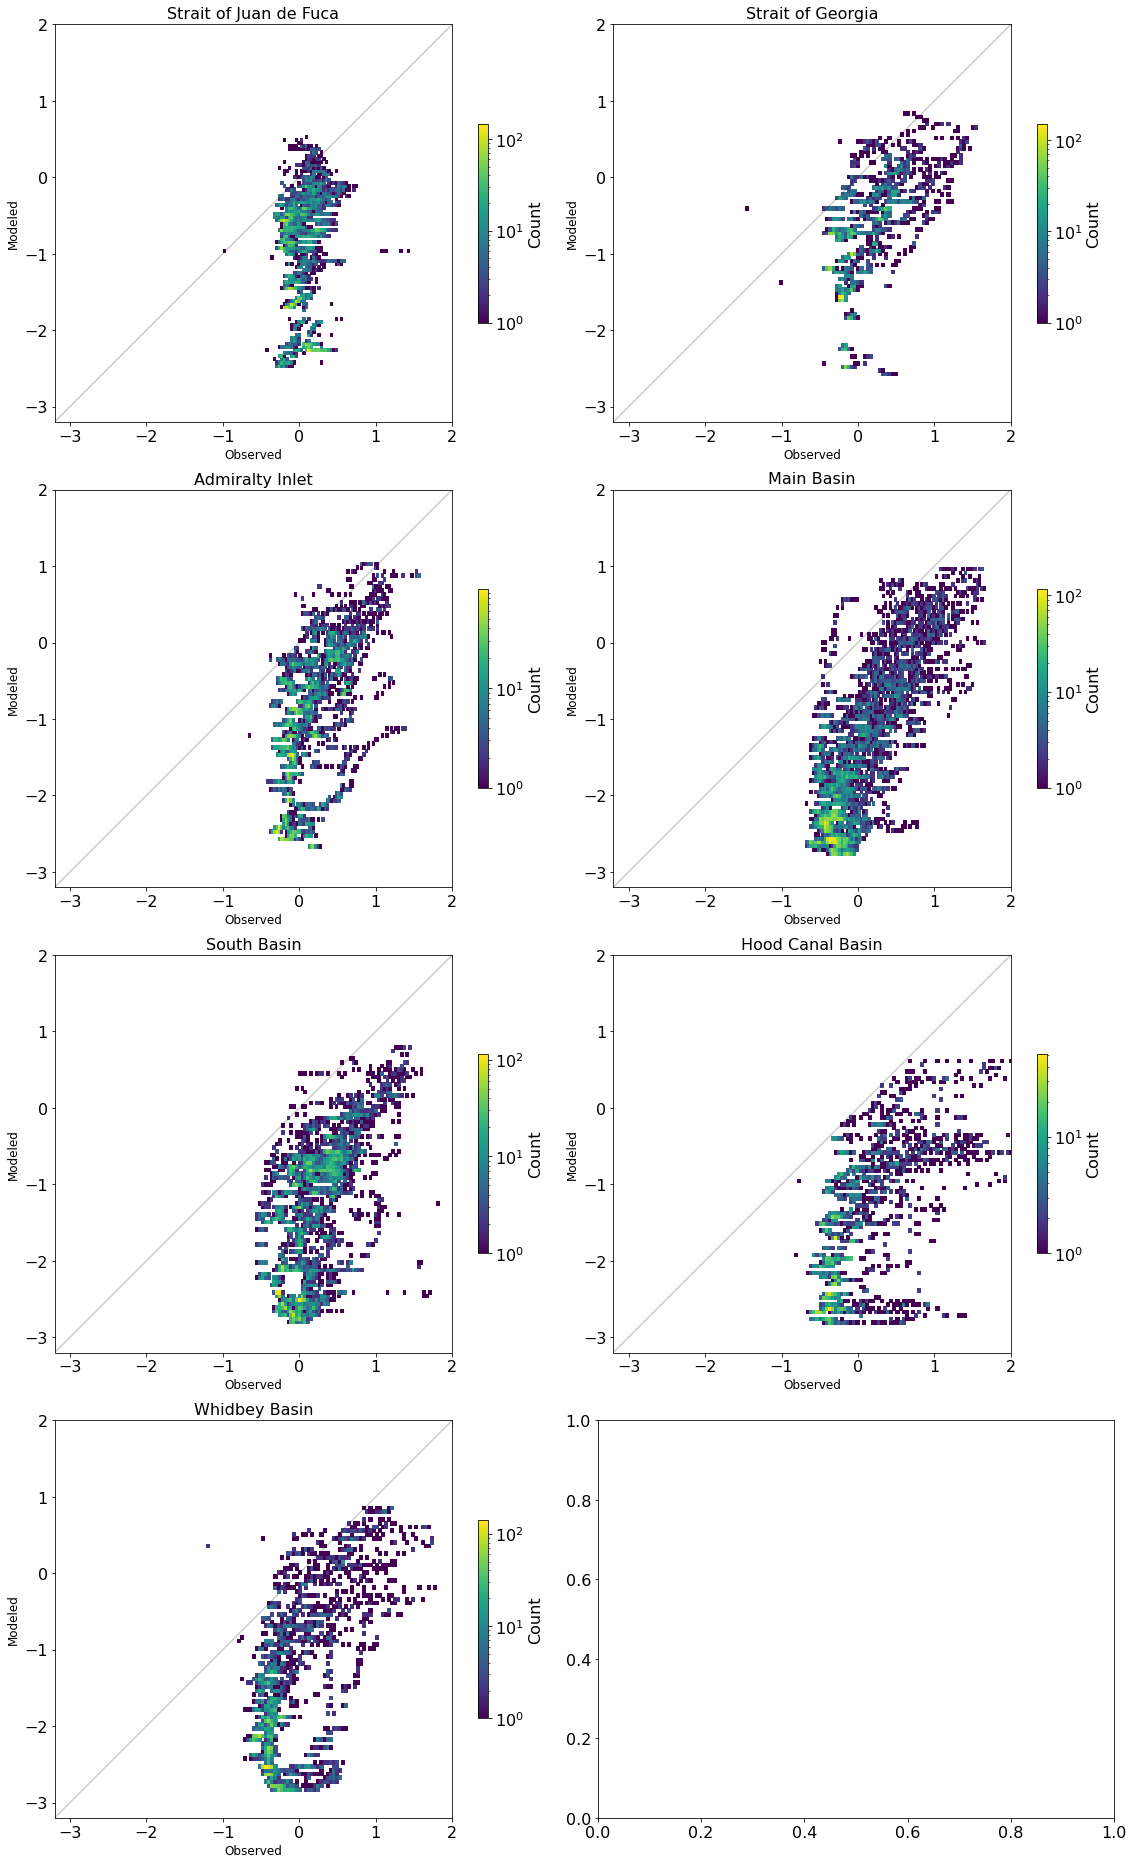

In [32]:
ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model vs observed comparisons for multiple seasons

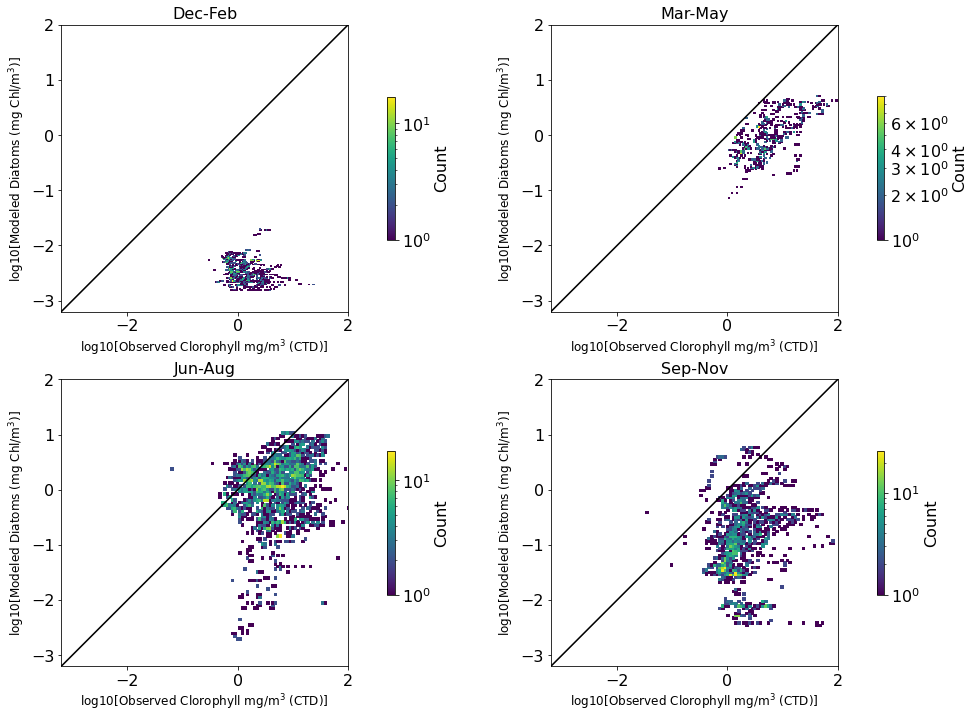

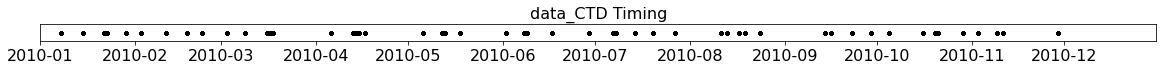

In [33]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (18,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Modeled Diatoms (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')   
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [34]:
obsvar='Chl'
modvar='mod_ciliates'

statsDict_Chl[year]['Ciliates']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Ciliates'][isub]=dict()
    var=statsDict_Chl[year]['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Ciliates'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

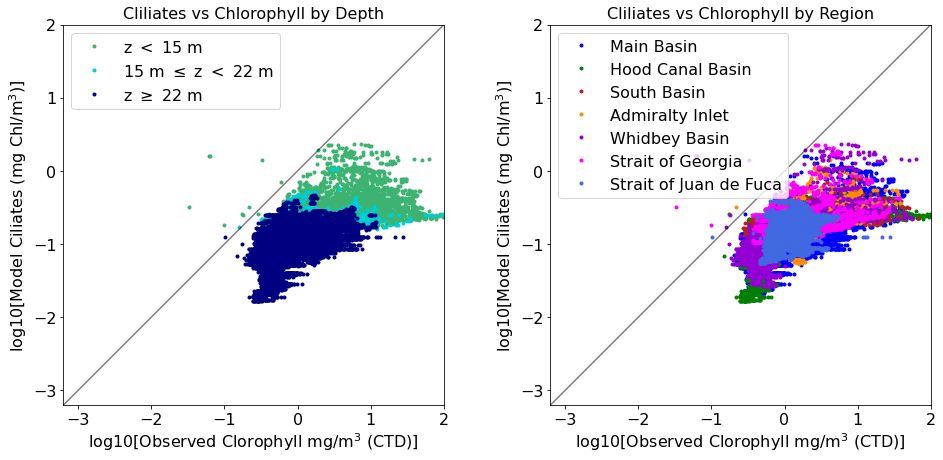

In [35]:
obsvar='log_Chl'
modvar='log_mod_ciliates'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Cliliates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Cliliates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of model ciliates vs observed chlorophyll

Text(0.5, 28.0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

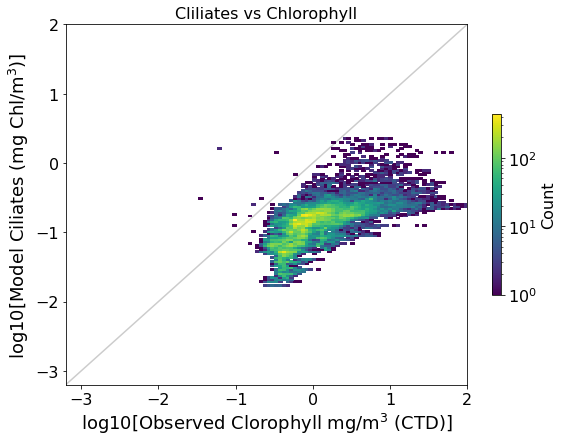

In [36]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Cliliates vs Chlorophyll')
ax.set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')

### 2D Histograms of individual regions

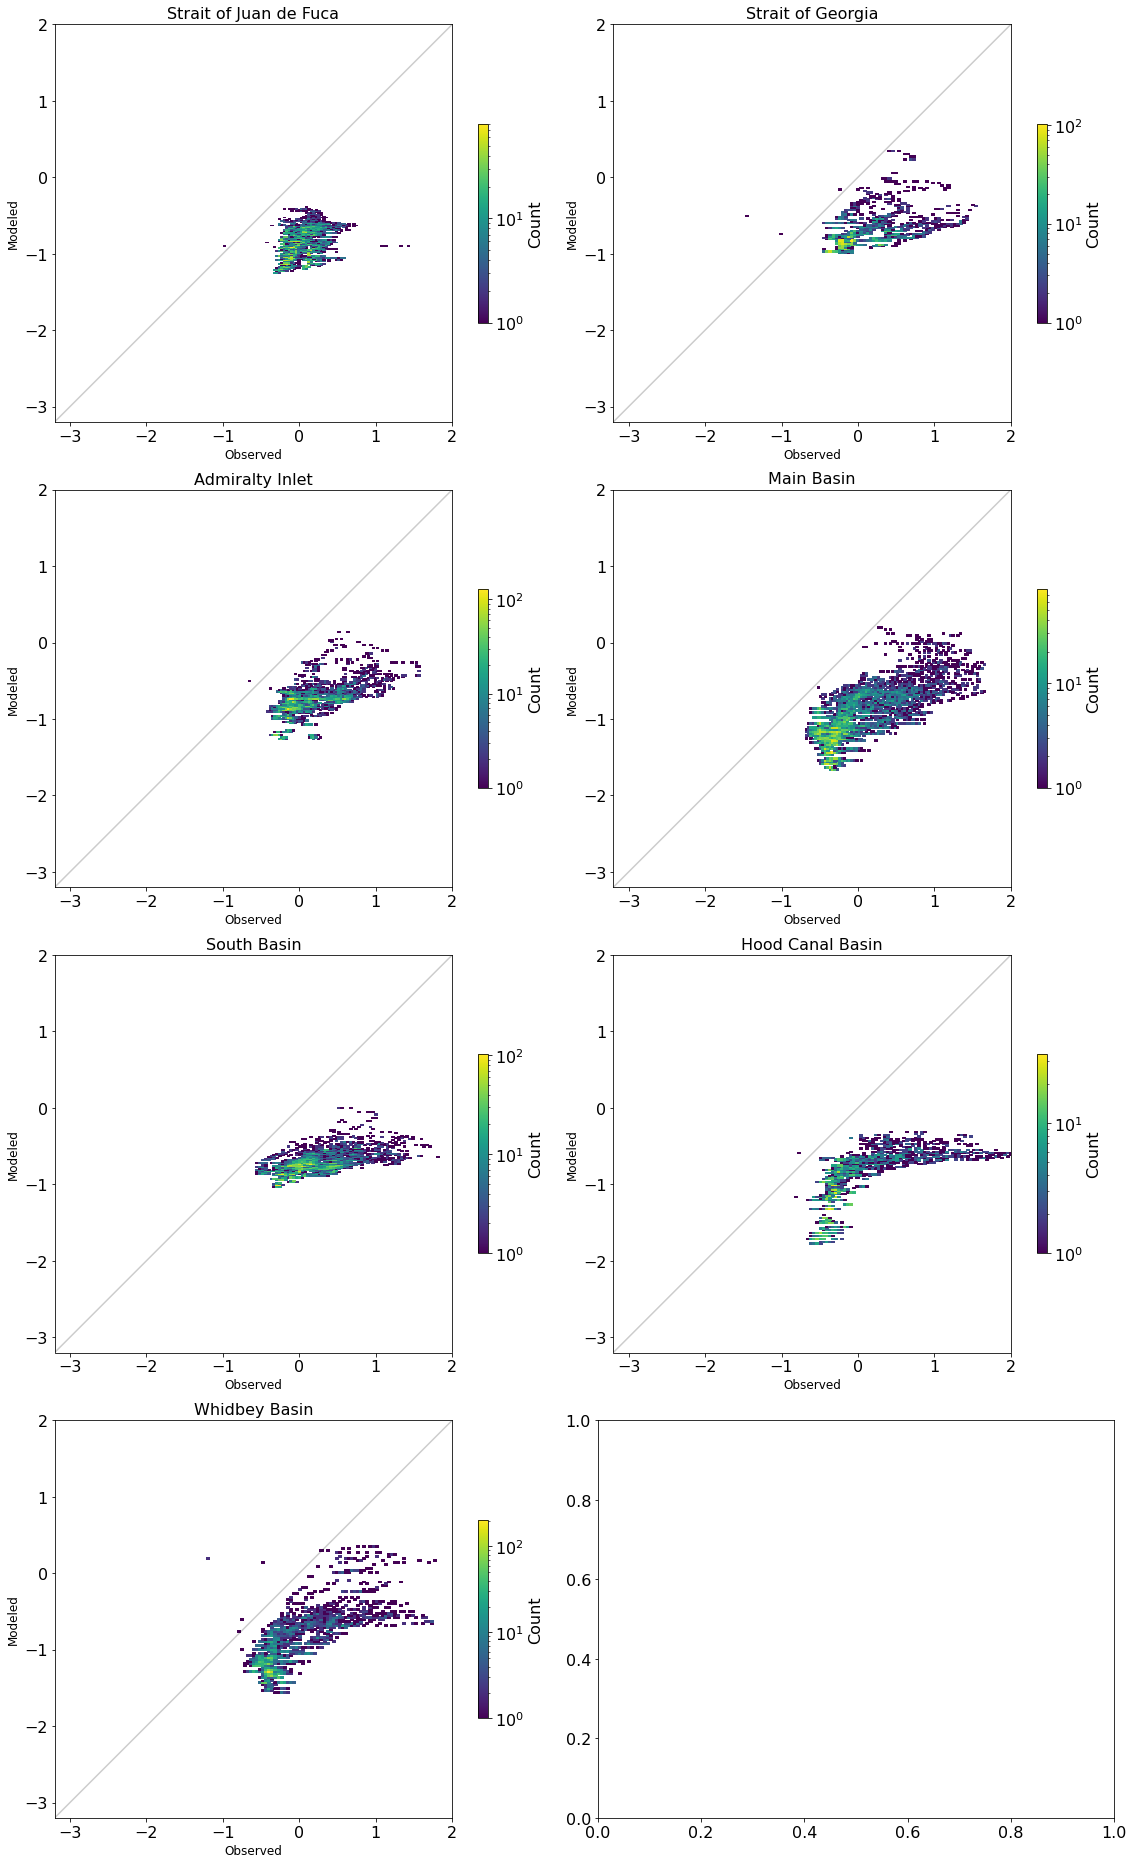

In [37]:
ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

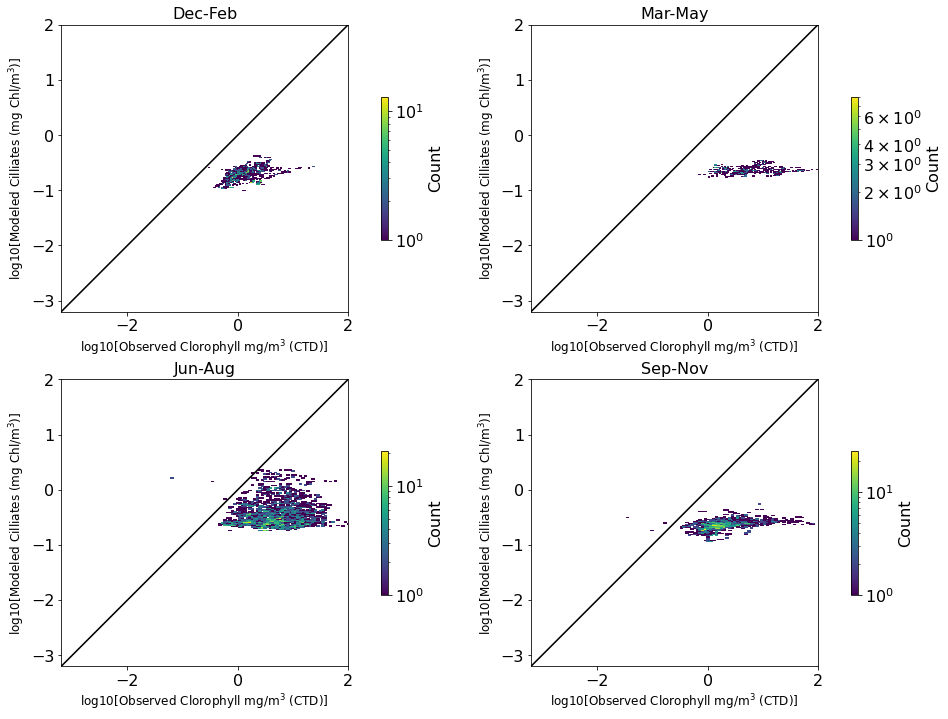

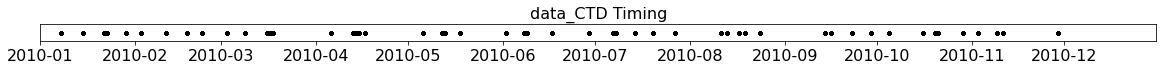

In [38]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (16,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Modeled Cilliates (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [39]:
obsvar='Chl'
modvar='mod_flagellates'

statsDict_Chl[year]['Flagellates']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['Flagellates'][isub]=dict()
    var=statsDict_Chl[year]['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['Flagellates'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

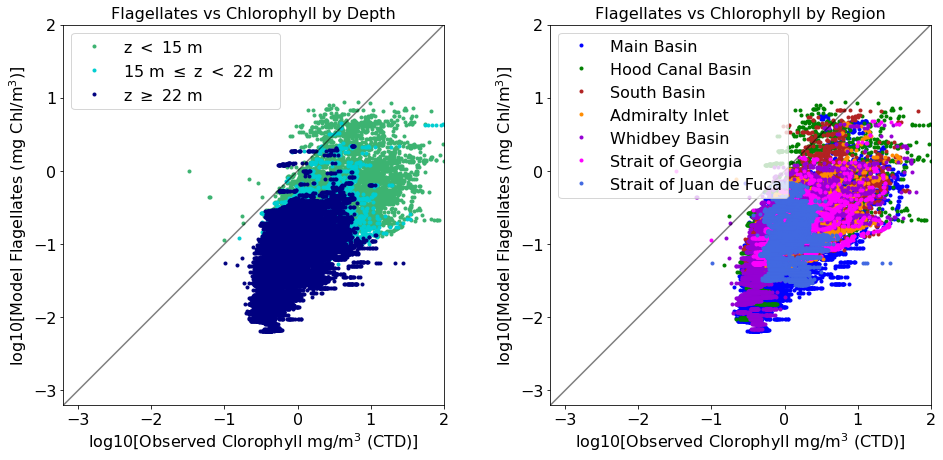

In [40]:
obsvar='log_Chl'
modvar='log_mod_flagellates'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Flagellates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')  

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Flagellates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of model flagellates vs observed Chlorophyll

Text(0.5, 28.0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

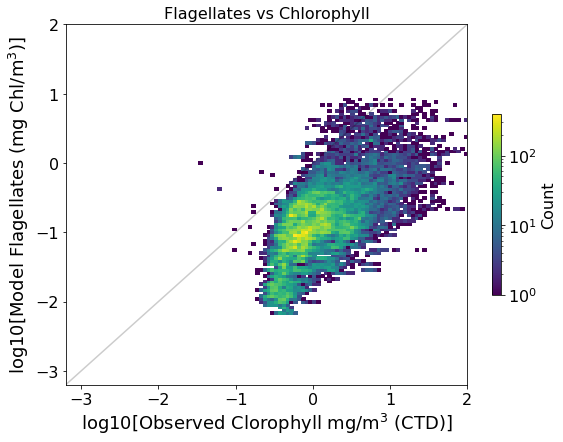

In [41]:
fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Flagellates vs Chlorophyll')
ax.set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histograms of individual regions

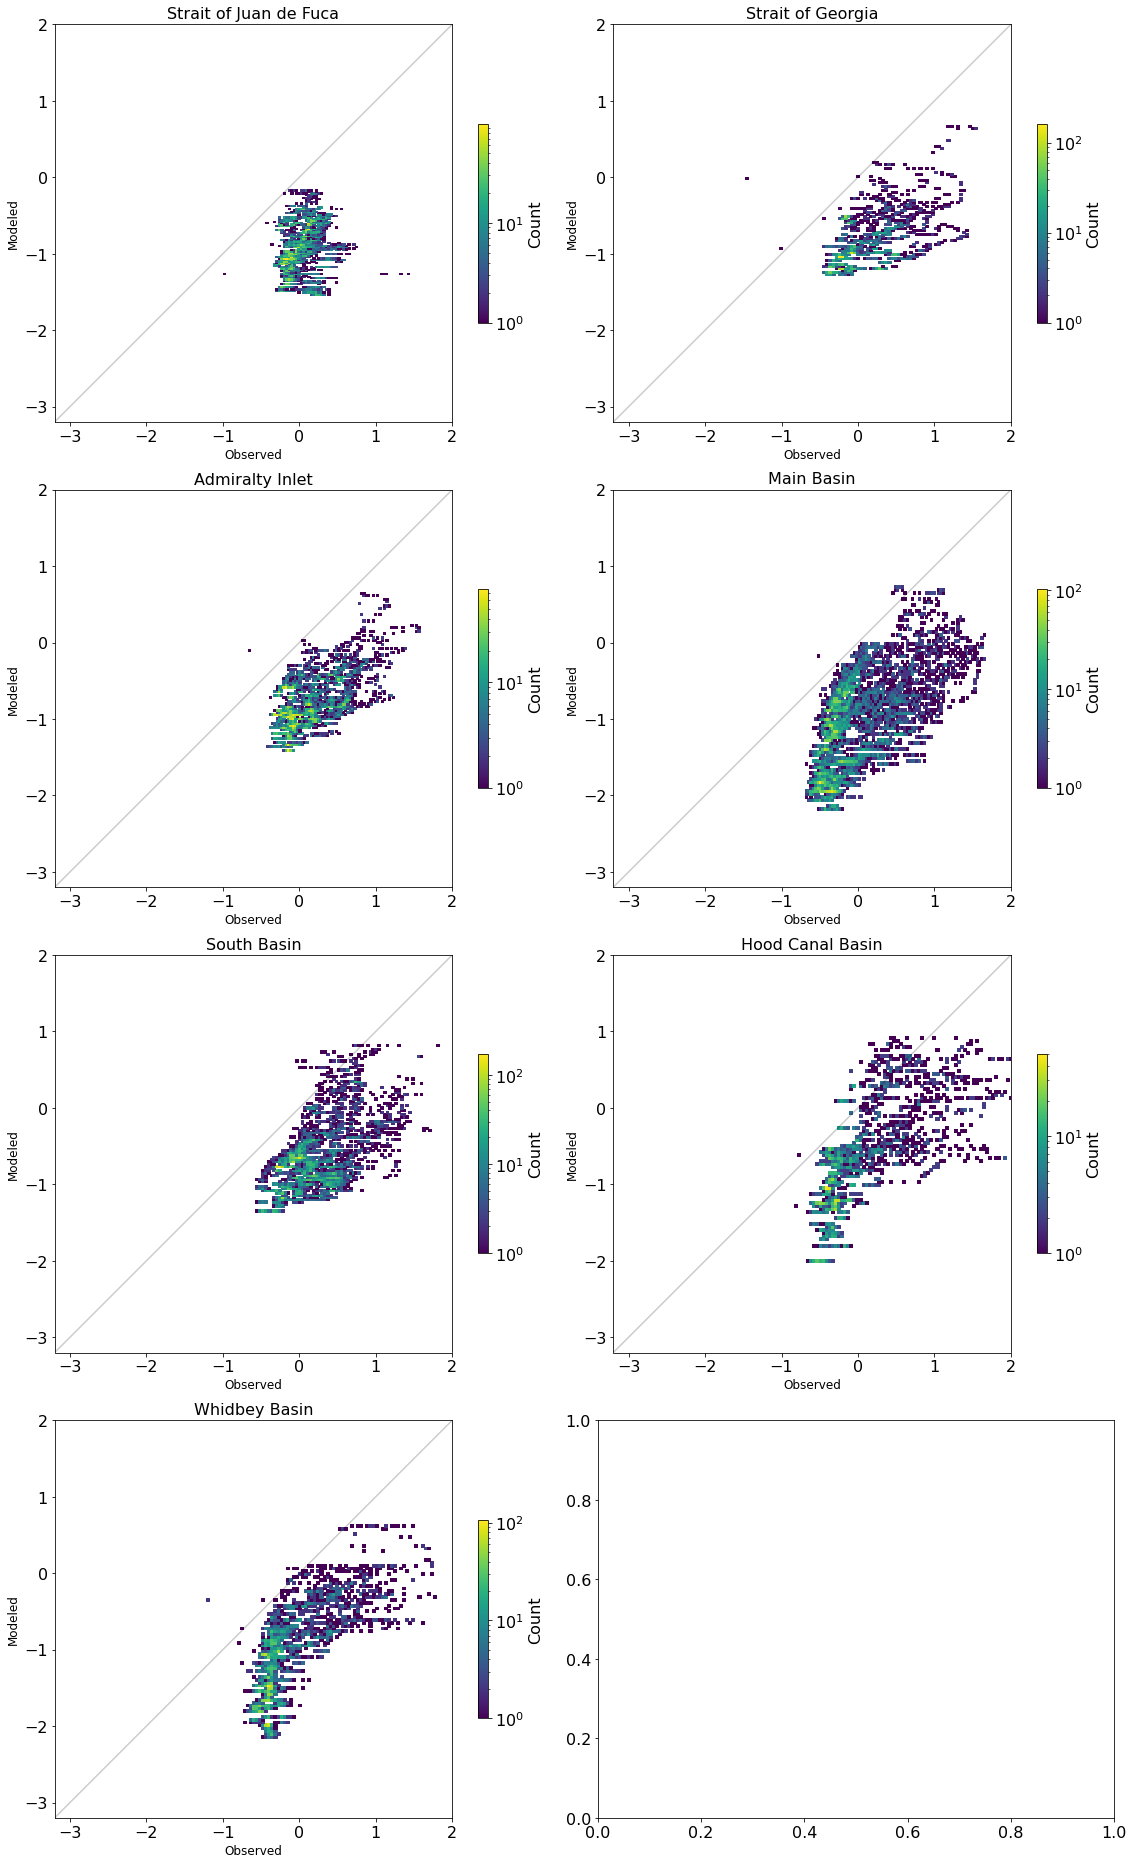

In [42]:
ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

### Model flagellates vs observed Chlorophyll comparisons for multiple seasons

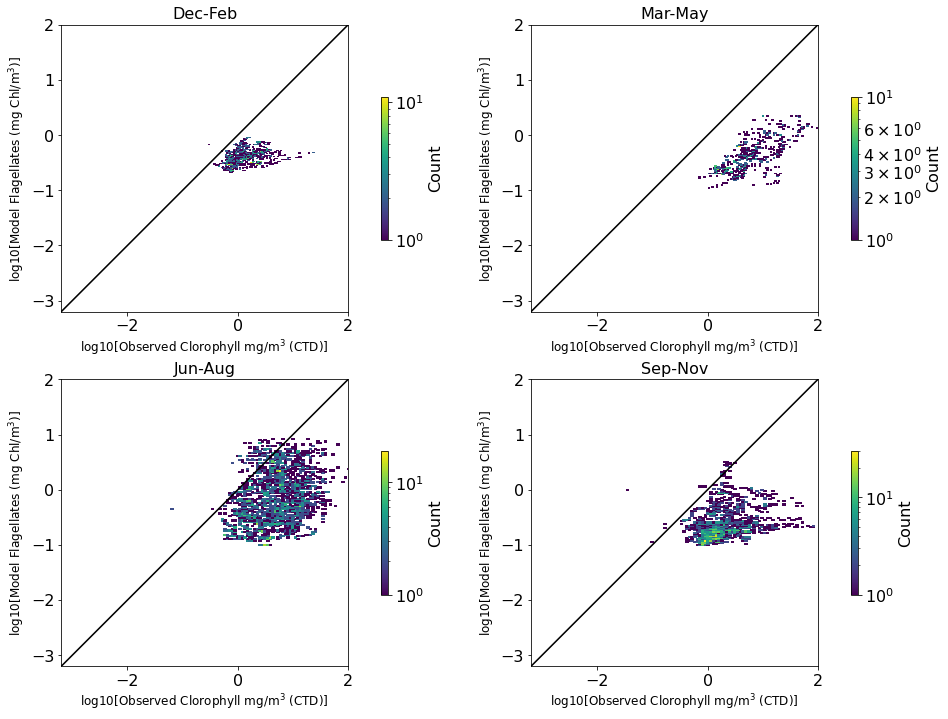

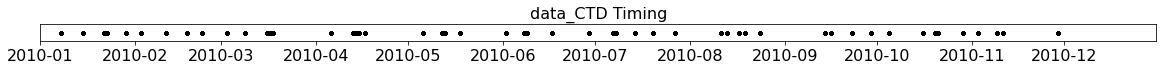

In [43]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (16,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,lims,season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]')
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [44]:
obsvar='Chl'
modvar='mod_Chl'

statsDict_Chl[year]['All']=OrderedDict()
for isub in statsubs_CTD:
    statsDict_Chl[year]['All'][isub]=dict()
    var=statsDict_Chl[year]['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs_CTD[isub].loc[:,[obsvar]], 
                                                                     statsubs_CTD[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl[year]['All'],level='Subset',suborder=list(statsubs_CTD.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ (CTD)]')

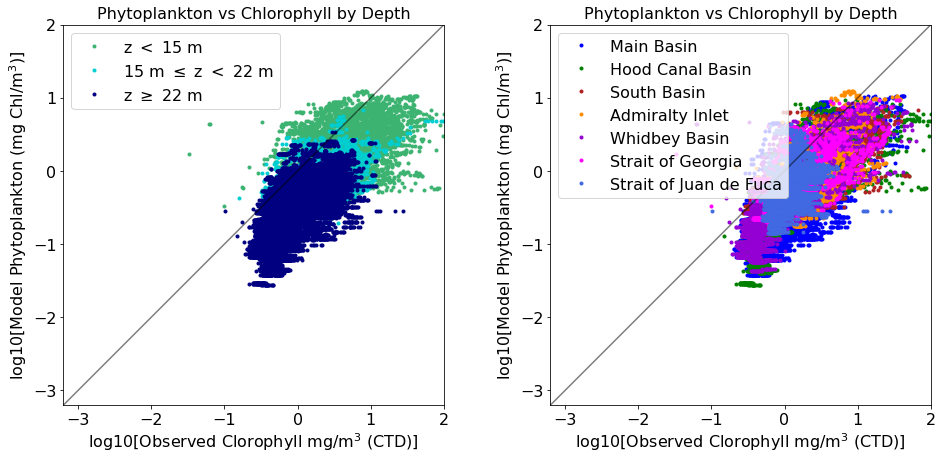

In [45]:
obsvar='log_Chl'
modvar='log_mod_Chl'

lims=(-3.2,2)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data_CTD,obsvar,modvar,lims)
ax[0].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

ps,l=ket.byRegion(ax[1],data_CTD,datreg_CTD,obsvar,modvar,lims)
ax[1].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[1].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ (CTD)]') 

### 2D Histogram of all model phytoplankton vs observed Chlorophyll

Text(0.5, 28.0, 'log10[Observed Chlorophyll mg/m$^3$ (CTD)]')

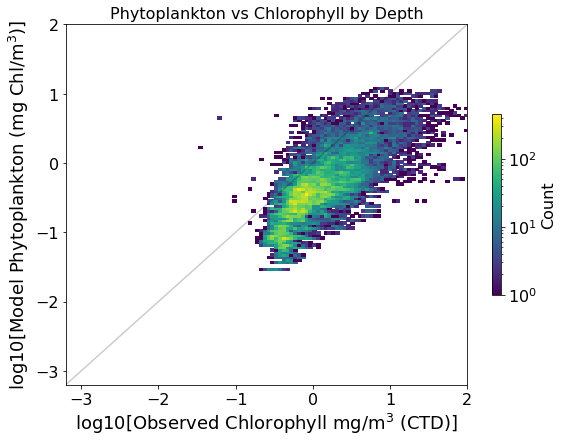

In [46]:
obsvar='log_Chl'
modvar='log_mod_Chl'

fig, ax = plt.subplots(1,1,figsize= (8,6))
ps = ket.hist2d(ax,fig,data_CTD,obsvar,modvar,(-3.2,2),fontsize=18)
ax.set_title('Phytoplankton vs Chlorophyll by Depth')
ax.set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax.set_xlabel('log10[Observed Chlorophyll mg/m$^3$ (CTD)]') 

### 2D Histograms of individual regions

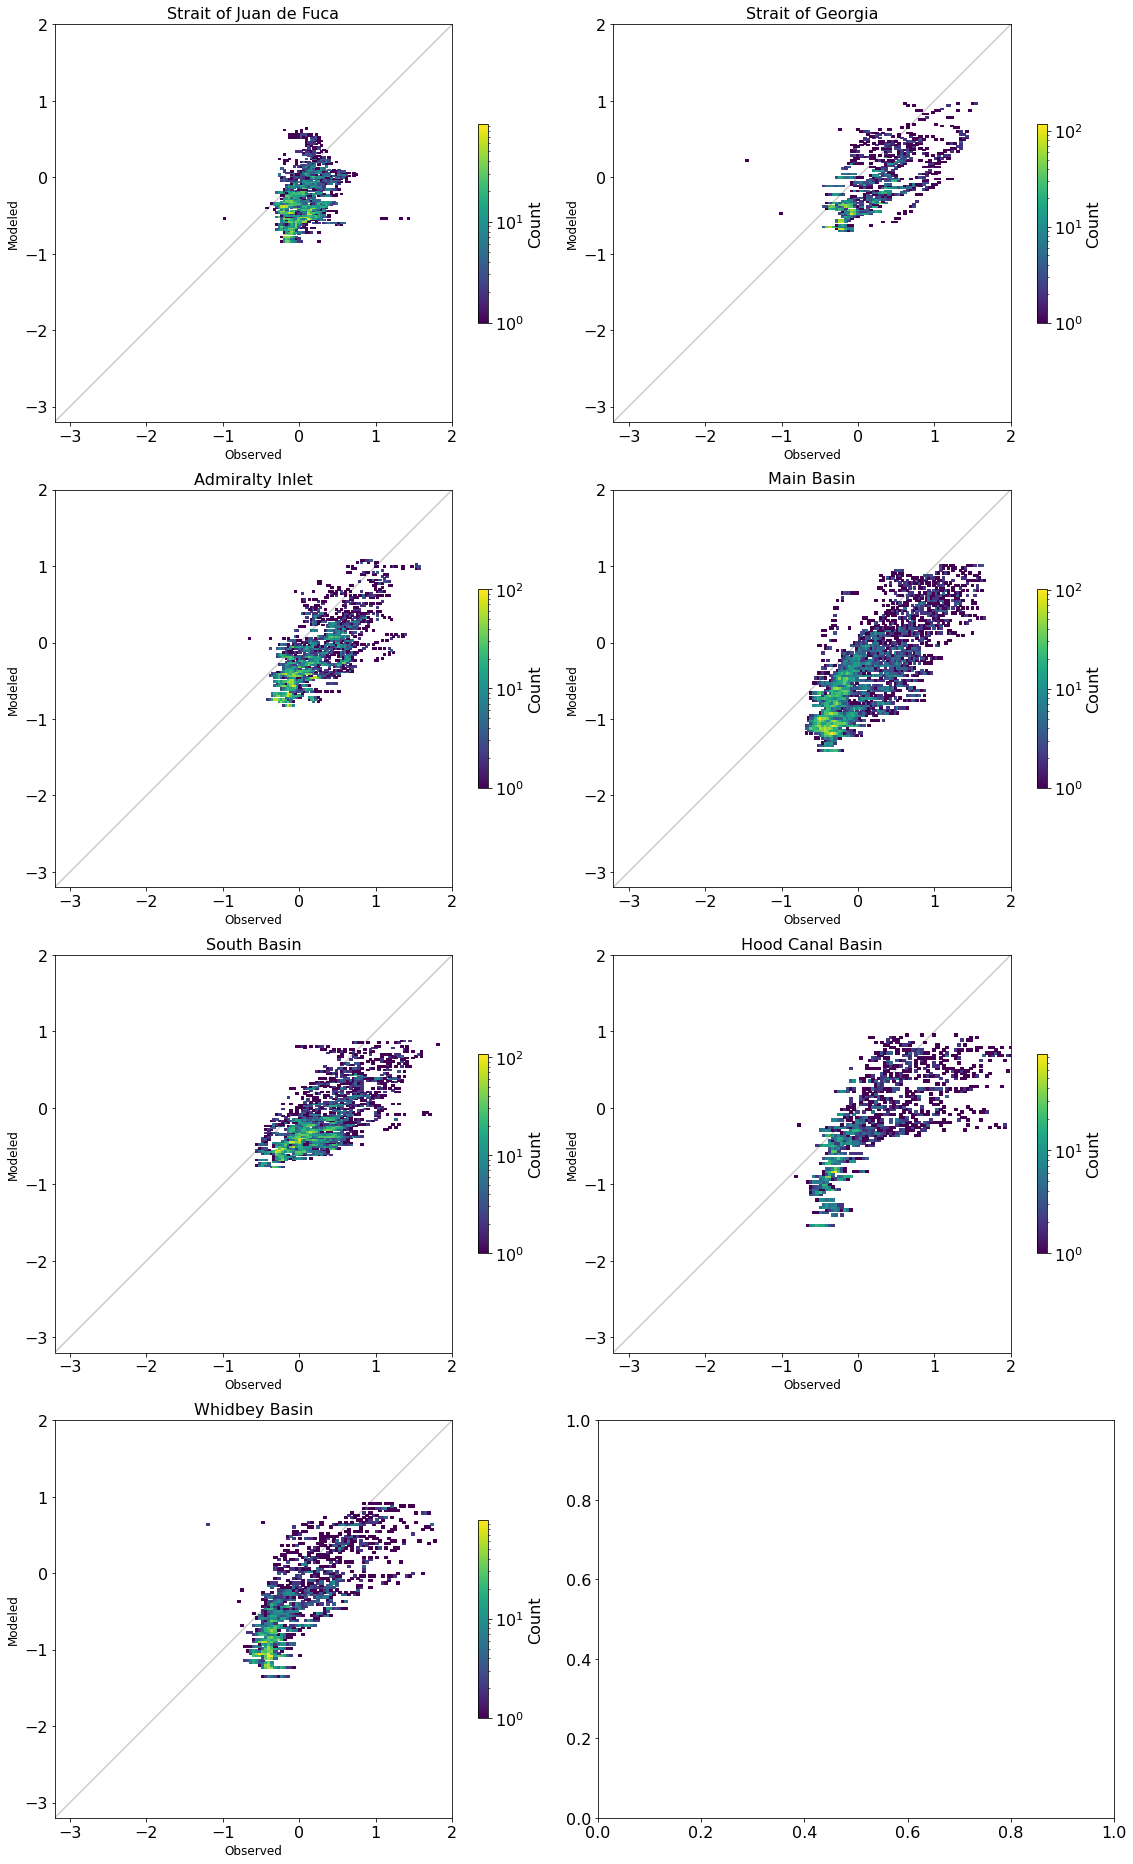

In [47]:
ket.byRegion_hist2d(datreg_CTD,regions,obsvar,modvar,lims)

## Model Chlorophyll vs observed Chlorophyll comparisons for multiple seasons

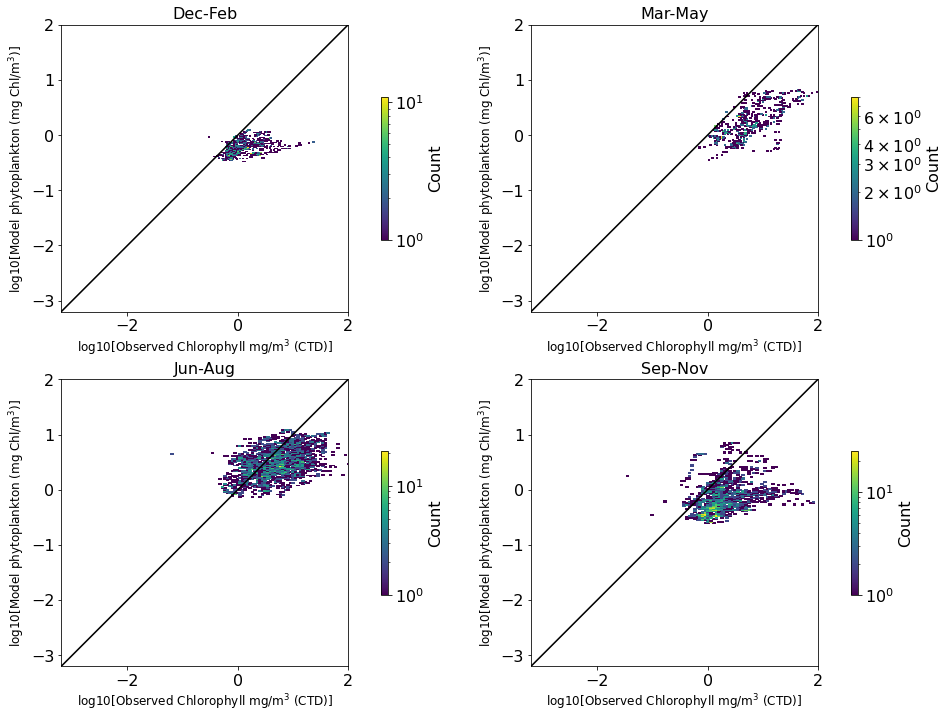

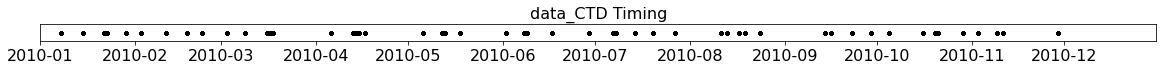

In [48]:
seasons=[DJF_CTD,MAM_CTD,JJA_CTD,SON_CTD]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(2,2,figsize = (16,10))
ket.bySeason_hist2d(ax,fig,seasons,obsvar,modvar,(-3.2,2),season_titles)
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('log10[Model phytoplankton (mg Chl/m$^3$)]')
        ax[i][j].set_xlabel('log10[Observed Chlorophyll mg/m$^3$ (CTD)]')
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data_CTD.dtUTC,np.ones(np.shape(data_CTD.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data_CTD Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [49]:
tbl,tdf=et.displayStats(statsDict_Chl[year],level='Variable',suborder=list(statsubs_CTD.keys()))
tbl